So far we have only looked at one-dimensional problems. Now let's move on to two dimensional systems!

In [1]:
import numpy as np
from types import SimpleNamespace
from scipy import integrate, sparse
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.style.use(['science', 'notebook', 'grid', 'vibrant'])
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

If we talk about two dimensions, we mean two *spatial* dimensions. This must not be confused with the 
dimensionality of the Hilbert space we use to describe the quantum system.

In ["Operators as Matrices in discrete Space"](https://znswanderer.github.io/physics/Discrete/) we discussed,
that we can discretize the (single) spatial dimension $x$ into $N$ discrete bins, which will result in 
a N-dimensional Hilbert space. The continuous spatial $x$ basis has infinite dimensions in Hilbert space.

To construct a finite dimensional Hilbert space for a system in a $x,y$-space, we will use
the [tensor product](https://en.wikipedia.org/wiki/Tensor_product) of the $x$ and $y$ basis. So
for example the $x$ momentum operator, $\hat p_x$, will only act on the $x$ part of the $x,y$ vectors,
the $y$ part is unchanged, which is a multiplication by the unit operator and the $y$ momentum operator
the other way around:

$$
\begin{align}
\hat p_x &= \hat p_\textrm{1d} \otimes {\bf 1} \\
\hat p_y &= {\bf 1} \otimes \hat p_\textrm{1d}
\end{align}
$$

In `scipy` this is done with the Kronecker product, which acts as a tensor product for matrices and vectors. We will now use these operators for the Hamiltonian of a particle in a two-dimensional box of size $L^2$:

In [3]:
def make_2d_box(N):
    L = 1
    x = np.linspace(0, L, N)
    y = np.linspace(0, L, N)

    # The second order derivative D2
    # (for simplicity we have dx=dy and so D2 is the same for x and y)
    dx = np.diff(x)[0]
    D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(N, N)) / dx**2
    One = sparse.eye(N)

    D2_x_2d = sparse.kron(D2, One)
    D2_y_2d = sparse.kron(One, D2)

    hbar = 1
    mass = 1
    T = -(hbar**2 / (2 * mass)) * (D2_x_2d + D2_y_2d)
    V = 0
    H = T + V
    return SimpleNamespace(**locals())

The function above will construct a two-dimensional box, using the Kronecker product.

For a small system we can take a look at the resulting Hamiltonian as a heatmap plot:

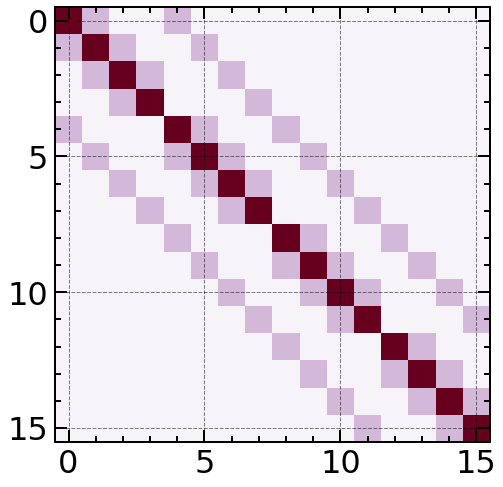

In [4]:
small = make_2d_box(N=4)
plt.imshow(np.abs(small.H.todense()), cmap='PuRd');

This is basically the [discrete Laplace operator](https://en.wikipedia.org/wiki/Discrete_Laplace_operator) in two dimensions as a band matrix, with the inner band at $\pm 1$ takes into account the Laplacian in one spatial direction and the other two bands at $\pm L$ is the Laplacian in the other dimension. (The empty spots in the inner band are because of the boundary conditions)

For finding the eigenvalues we could use the function `scipy.linalg.eigvals_banded`, but as we would have to include all the empty bands between $1$ and $L$ the amount of data for this band matrix will increase with $\mathcal{O}(L^2)$, just like a regular matrix. Maybe there is a clever way to deal with this, but I think the easiest way to procede is just using the routines for sparse matrices. 

The analytical eigenfunctions of the particle in a 2d box are

$$
\psi(x,y) = \sin (n_x \pi x / L ) \sin (n_y \pi x/ L)
$$

with $n_x = 1, 2, \dots$ and $n_y = 1, 2, \dots$.

The [energy eigenvalues](https://en.wikipedia.org/wiki/Particle_in_a_box#Higher-dimensional_boxes) are

$$
E_{n_x, n_y} = \frac{\hbar^2}{2m} \frac{\pi^2}{L^2} \left( n_x^2 +n_y^2\right)
$$

Now we choose a discretisation with $N=300$ and calculate the eigenvalues and vectors numerically:

In [5]:
def calc_box_2d(box):
    # Takes about 1 minute on a mac book pro 2019, 2.6 GHz 6-Core, for N=300
    eigs, eigv = sparse.linalg.eigsh(box.H, k=10, which='SM')
    return SimpleNamespace(**locals())

box_2d = make_2d_box(N=300)
res_box_2d = calc_box_2d(box_2d)

And compare them with the analytical results:

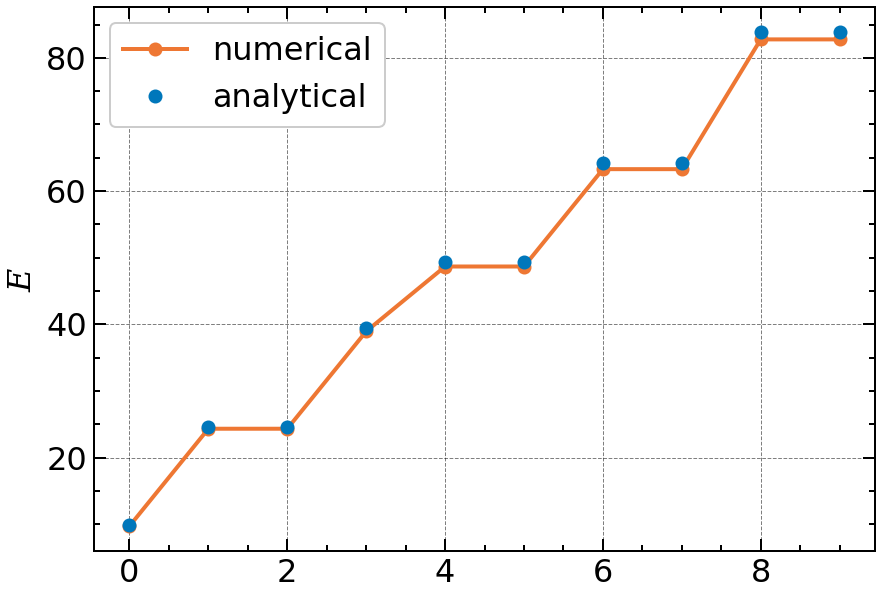

In [6]:
nx, ny = np.meshgrid(np.arange(1, 5), np.arange(1, 5))
ana_eigs = np.sort(((box_2d.hbar**2 / (2*box_2d.mass)) * (np.pi**2/box_2d.L**2) * (nx**2 + ny**2)).flatten())[0:10]

plt.figure(figsize=(7,5))
plt.plot(res_box_2d.eigs, 'o-', label='numerical')
plt.plot(ana_eigs, 'o', label='analytical')
plt.ylabel("$E$")
plt.legend();

As one can see, the numerical results are (for small energies) quite close tbox_2d analytical ones.
We can also see, that some energy levels are degenerated.

We can also make a 2d heatmap plot of the eigenvectors:

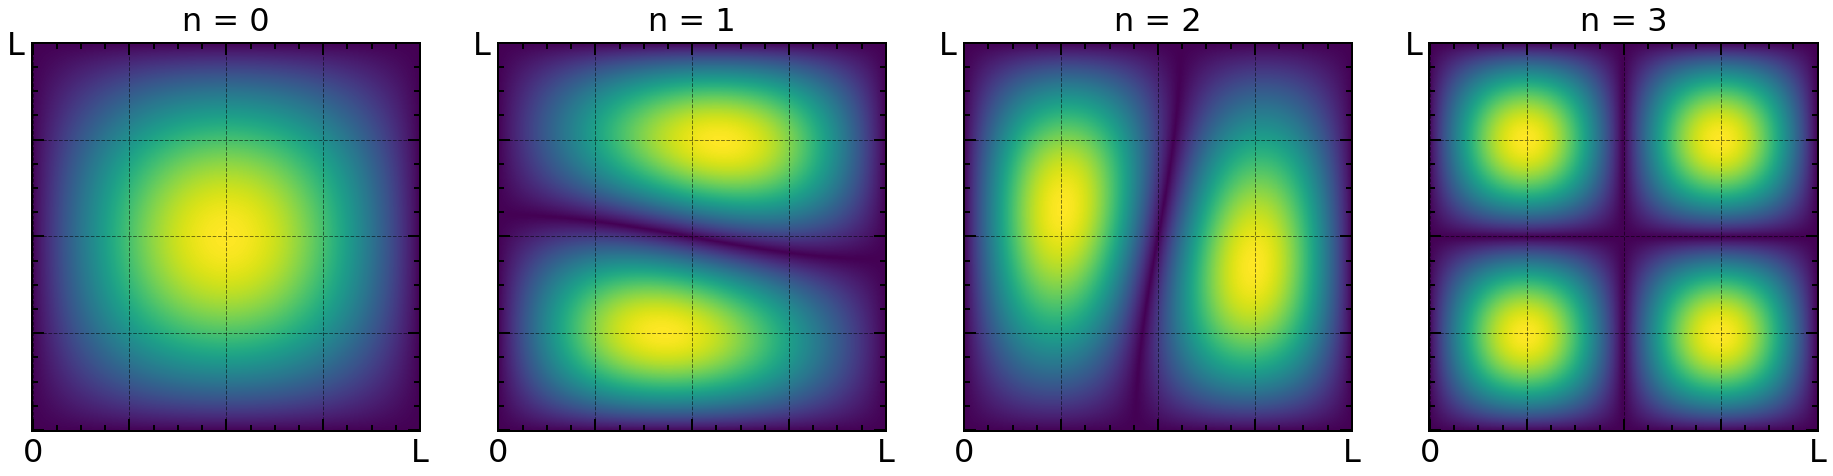

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(16,6))

for n in range(1, 5):
    ax = axs[n-1]
    psi = res_box_2d.eigv.T[n-1]  
    psi_n = np.reshape(psi, (box_2d.N, box_2d.N))
    ax.set_title("n = %d" % (n-1))
    ax.imshow(np.abs(psi_n), origin='lower')
    ax.set_xticks([0, len(box_2d.x)//4, len(box_2d.x)//2, (3*len(box_2d.x))//4, len(box_2d.x)])
    ax.set_xticklabels(['0', '', '', '', 'L'])
    ax.set_yticks([0, len(box_2d.y)//4, len(box_2d.y)//2, (3*len(box_2d.y))//4, len(box_2d.y)])
    ax.set_yticklabels(['', '', '', '', 'L'])

(We plotted $\vert\psi(x,y)\vert$ and not $\vert\psi(x,y)\vert^2$, because this way the problem is easier to spot)

One can easily see, that the eigenvectors for $n=0$ and $n=3$ are $\psi_0 = \sin (\pi x /L) \sin (\pi y / L)$ 
and $\psi_3 = \sin (2\pi x /L) \sin (2\pi y / L)$, but the graphs for $n=1$ and $n=2$ seem to be somewhat skewed.
This is because the energy levels for $n=1$ and $n=2$ are degenerated and the eigensolver returned some arbitrary 
linear combinations of the symmetric eigenvectors.

We can force the eigensolver to yield the symmetric eigenfunctions by introducing a small arbitrary
term into the Hamiltonian which will break the degeneracy, like for example:

$$
\hat H´ = \hat H + i \hat p_x^2 / (10 m)
$$

(We made the artificial addition such, that it will result just in a purely imaginary 
additional term in the energy levels).

For finding the eigenvalues we must now use the functions `eigs` and not `eigsh` as 
the matrix is no longer self-adjoint:

In [8]:
def calc_box_2d_(box):
    # Takes about one minute on a mac book pro 2019, 2.6 GHz 6-Core, for N=300
    H_ = box.H - 1j * box.hbar**2 * box.D2_x_2d / (10 * box.mass)
    eigs, eigv = sparse.linalg.eigs(H_, k=10, which='SM')
    return SimpleNamespace(**locals())

res_box_2d_ = calc_box_2d_(box_2d)

We can now see the $n_x$ contribution directly in the imaginary part of the eigenvalues:

In [9]:
np.round(res_box_2d_.eigs, 3)

array([ 9.739 +0.974j, 24.346 +0.974j, 24.346 +3.895j, 38.954 +3.895j,
       48.691 +0.974j, 48.691 +8.764j, 63.298 +3.895j, 63.298 +8.764j,
       82.769 +0.974j, 82.769+15.58j ])

The real part of the eigenvalues are the same as the ones found with `eigsh`:

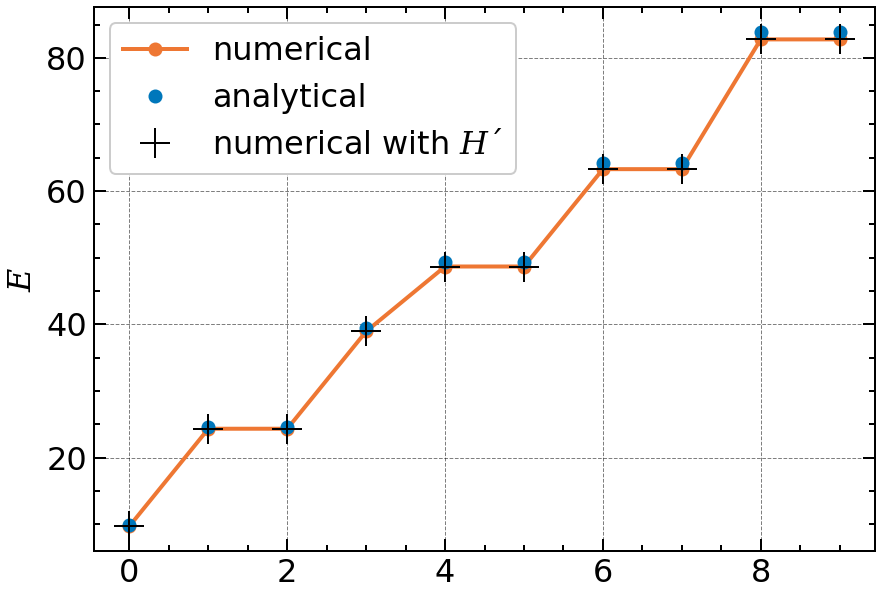

In [10]:
plt.figure(figsize=(7,5))
plt.plot(res_box_2d.eigs, 'o-', label='numerical')
plt.plot(ana_eigs, 'o', label='analytical')
plt.plot(np.real(res_box_2d_.eigs), 'k+', markersize=15, label='numerical with $H´$')
plt.ylabel("$E$")
plt.legend();

If we now take a look at the eigenfunctions, we see that they are symmetrical:

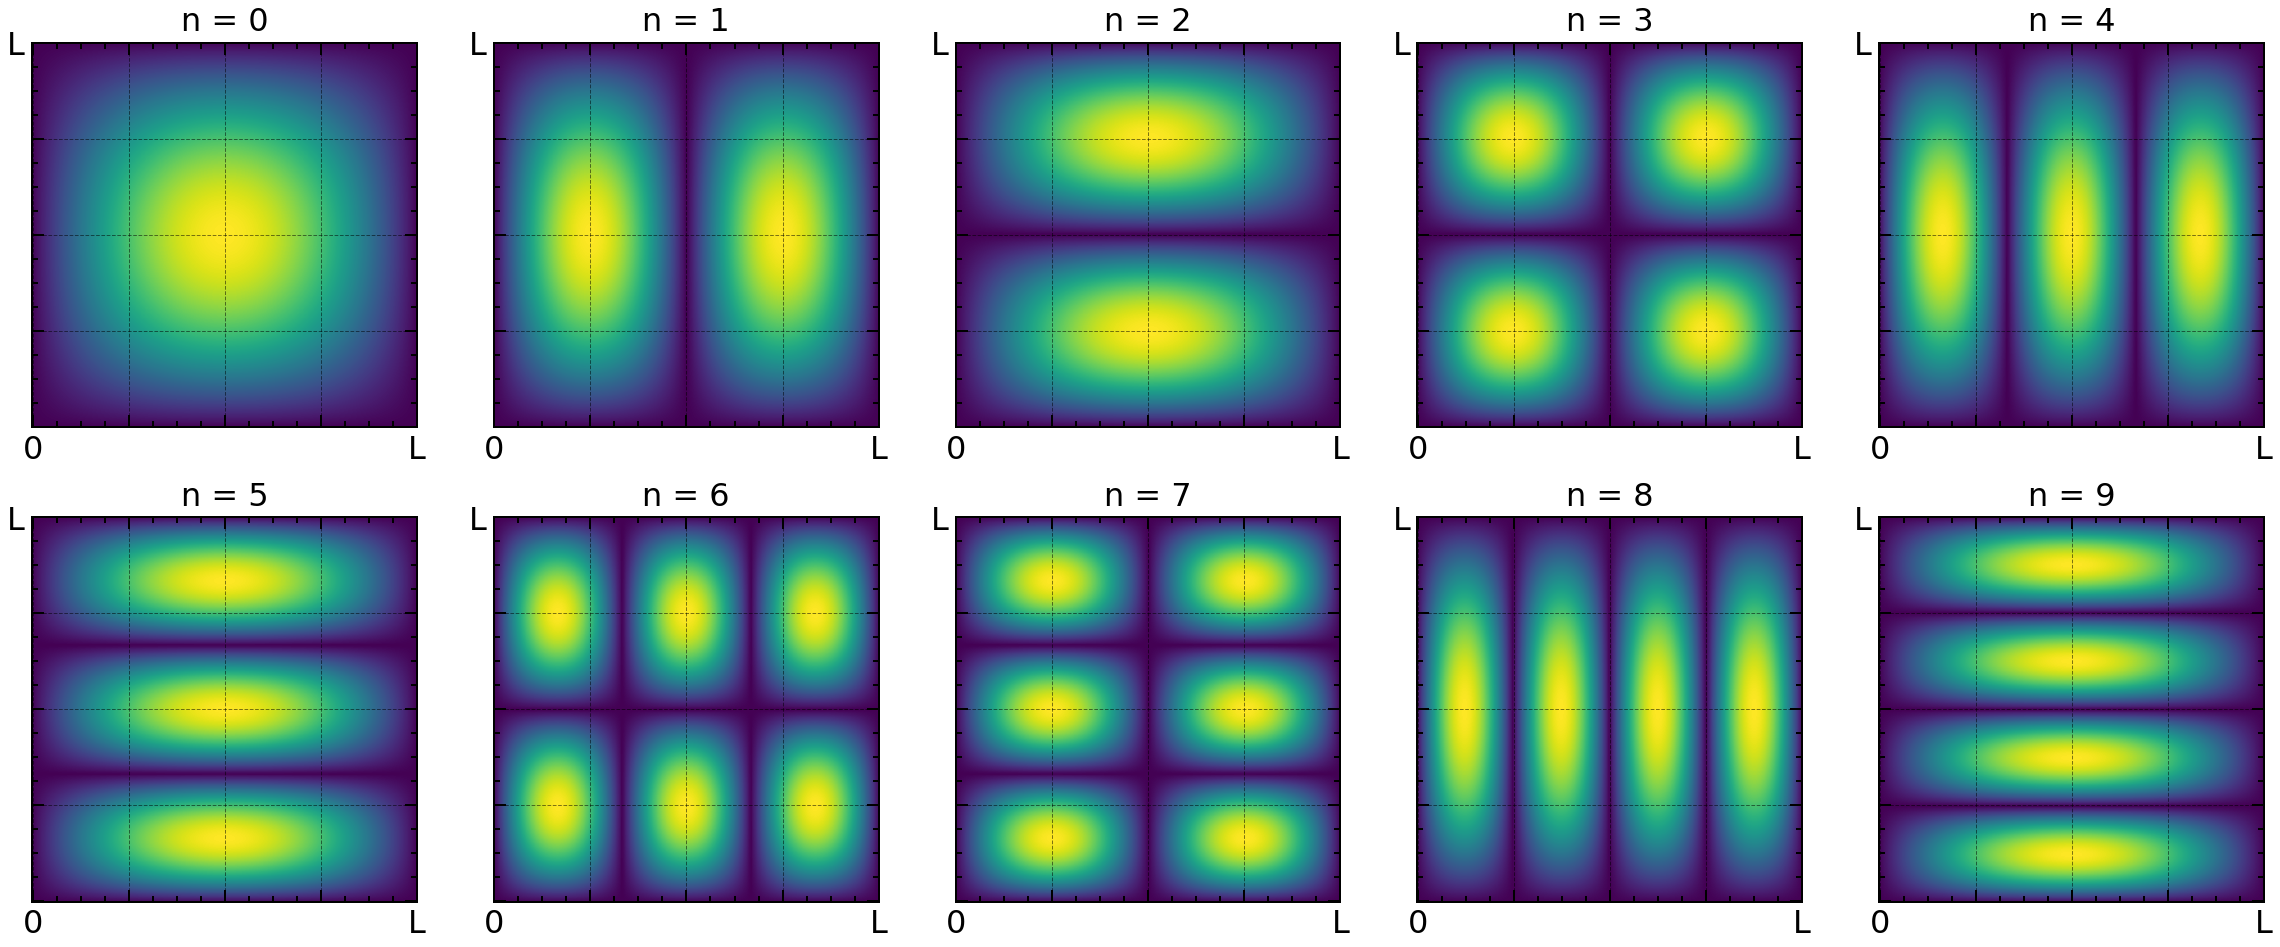

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(20,8))

for n in range(1, 11):
    ax = axs[(n-1)//5][(n-1)%5]
    psi = res_box_2d_.eigv.T[n-1]  
    psi_n = np.reshape(psi, (box_2d.N, box_2d.N))
    ax.set_title("n = %d" % (n-1))
    ax.imshow(np.abs(psi_n), origin='lower')
    ax.set_xticks([0, len(box_2d.x)//4, len(box_2d.x)//2, (3*len(box_2d.x))//4, len(box_2d.x)])
    ax.set_xticklabels(['0', '', '', '', 'L'])
    ax.set_yticks([0, len(box_2d.y)//4, len(box_2d.y)//2, (3*len(box_2d.y))//4, len(box_2d.y)])
    ax.set_yticklabels(['', '', '', '', 'L'])

That's it for this time. One interesting bit is, that as the two dimensions ($x$ and $y$) do not influence each other in the Hamiltonian, we can view this 2d-system as two independent 1d-systems. I am planning to look into this in more detail in one of the next blog posts for the 2d harmonic oscillator.